Importing libraries

In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import time
import json

In [2]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Reading the files into training and validation datasets with a 80%-20% split

In [3]:
train_dataset, val_dataset = tf.keras.utils.image_dataset_from_directory(
    'Datasets/VERA/',
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='both'
)

Found 6400 files belonging to 160 classes.
Using 5120 files for training.
Using 1280 files for validation.


In [4]:
train_batches = len(train_dataset)

test_size = 0.2

# Calculate sizes for 80-20 split
train_size = int((1 - test_size) * train_batches)
test_size = int(test_size * train_batches)

# Split the dataset
test_dataset = train_dataset.skip(train_batches - test_size)
train_dataset = train_dataset.take(train_size)

In [5]:
def get_dataset_size(dataset):
    num_batches = len(dataset)
    return num_batches * 32

print(f"Total number of samples in train_dataset: {get_dataset_size(train_dataset)} ({len(train_dataset)} batches of 32)")
print(f"Total number of samples in validation_dataset: {get_dataset_size(val_dataset)} ({len(val_dataset)} batches of 32)")
print(f"Total number of samples in test_dataset: {get_dataset_size(test_dataset)} ({len(test_dataset)} batches of 32)")

Total number of samples in train_dataset: 4096 (128 batches of 32)
Total number of samples in validation_dataset: 1280 (40 batches of 32)
Total number of samples in test_dataset: 1024 (32 batches of 32)


Prefetching data into GPU memory to optimize training process

In [6]:
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

Visualizing some training images

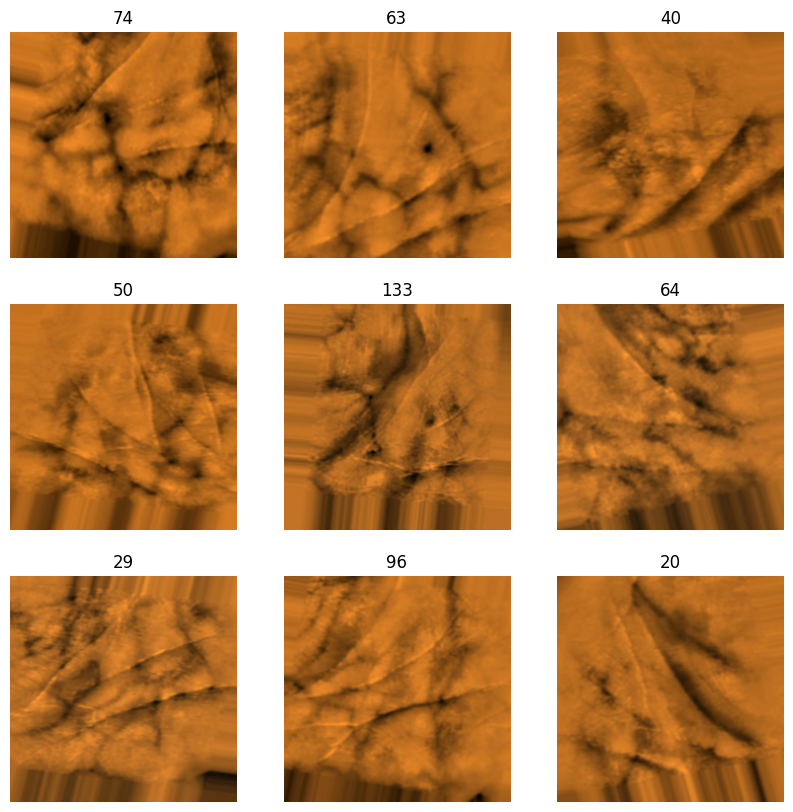

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

Creating data augmentation layer 

In [8]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
        layers.RandomTranslation(0.1, 0.1),
        layers.RandomHeight(0.1),
        layers.RandomWidth(0.1),
    ]
)

Visualizing the data augmentations on a random training image

In [9]:
# plt.figure(figsize=(10, 10))
# for images, _ in train_dataset.take(1):
#     for i in range(9):
#         augmented_images = data_augmentation(images)
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(augmented_images[0].numpy().astype("uint8"))
#         plt.axis("off")

Define some key constants

In [10]:
num_classes = 110
image_size = (224, 224, 3)

Defining function to return AlexNet Model with reduced number of filters as per research paper

In [11]:
def make_alexnet_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Layer 1: Convolutional + Max Pooling
    # x = data_augmentation(inputs)
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, (3, 3), strides=(4, 4), activation='relu', padding='valid')(inputs)
    x = layers.MaxPooling2D((3, 3), strides=(2,2))(x)
    x = layers.BatchNormalization()(x)

    # Layer 2: Convolutional + Max Pooling
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2,2))(x)
    x = layers.BatchNormalization()(x)

    # Layer 3: Three Convolutional Layers
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    # Layer 4: Max Pooling
    x = layers.MaxPooling2D((3, 3), strides=(2,2))(x)

    # Flatten and Fully Connected Layers
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    return keras.Model(inputs, outputs)


Defining function to return VGG16 Model with reduced number of filters as per research paper

In [12]:
def make_vgg16_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Block 1
    # x = data_augmentation(inputs)
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)d
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)
    x = layers.BatchNormalization()(x)


    # Block 2
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Block 3
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Block 4
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Block 5
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Flatten and Fully Connected Layers
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return keras.Model(inputs, outputs)

Defining function to return VGG19 Model with reduced number of filters as per research paper

In [13]:
def make_vgg19_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Block 1
    # x = data_augmentation(inputs)
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 2
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 3
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 4
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 5
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Flatten and Fully Connected Layers
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return keras.Model(inputs, outputs)


In [14]:
# base_model = keras.applications.AlexNet(
#     include_top=False,
#     weights='imagenet',
#     input_shape=(224, 224, 3)
# )
# base_model.trainable = False  # Freeze the base model

# model = keras.Sequential([
#     base_model,
#     layers.Flatten(),
#     layers.Dense(4096, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(4096, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(num_classes, activation='softmax')
# ])

# model.compile(
#         optimizer=keras.optimizers.Adam(1e-4),
#         loss="sparse_categorical_crossentropy",
#         metrics=["accuracy"],
#     )

In [15]:
# model.fit(
#         train_dataset,
#         epochs=20,
#         validation_data=val_dataset,
#         verbose=1,
#     )

In [16]:
# test_loss, test_accuracy = model.evaluate(test_dataset)

# print(f'\x1b[34m{name} Model Results:\x1b[0m')
# print(f"Test accuracy: {test_accuracy*100:.2f}%")
# print(f"Test loss: {test_loss:.4f}")
# print()

Training each model

In [18]:
from tqdm import tqdm
num_epochs = 30

models = {
    # "AlexNet": make_alexnet_model(input_shape=image_size, num_classes=num_classes),
    "VGG16": make_vgg16_model(input_shape=image_size, num_classes=num_classes),
    # "VGG19": make_vgg19_model(input_shape=image_size, num_classes=num_classes),
}

model_histories = {}

for name, model in models.items():
    print(f'\x1b[34mTraining {name} Model...\x1b[0m')
    model.compile(
        optimizer=keras.optimizers.Adam(1e-4),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    start = time.time()
        
    # Wrap model.fit with tqdm for a progress bar
    progress_bar = tqdm(total=num_epochs, position=0, leave=True)
    history = model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=val_dataset,
        verbose=1,
        callbacks=[
            tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: progress_bar.update(1)),
        ]
    )
    progress_bar.close()
    
    model_histories[name] = history
    
    end = time.time()
    print(f'Finished training {name} in {end-start:.2f}s\n')


Training VGG16 Model...


  3%|▎         | 1/30 [00:48<23:39, 48.96s/it]

Epoch 1/30


128/128 [==============================] - ETA: 0s - loss: 5.0720 - accuracy: 0.0054

  3%|▎         | 1/30 [00:25<12:08, 25.11s/it]

128/128 [==============================] - 25s 188ms/step - loss: 5.0720 - accuracy: 0.0054 - val_loss: 5.0753 - val_accuracy: 0.0055
Epoch 2/30
128/128 [==============================] - ETA: 0s - loss: 4.8079 - accuracy: 0.0327

  7%|▋         | 2/30 [00:48<11:22, 24.38s/it]

128/128 [==============================] - 24s 185ms/step - loss: 4.8079 - accuracy: 0.0327 - val_loss: 4.7955 - val_accuracy: 0.0531
Epoch 3/30
128/128 [==============================] - ETA: 0s - loss: 4.3900 - accuracy: 0.0701

 10%|█         | 3/30 [01:12<10:53, 24.21s/it]

128/128 [==============================] - 24s 187ms/step - loss: 4.3900 - accuracy: 0.0701 - val_loss: 4.3362 - val_accuracy: 0.0945
Epoch 4/30
128/128 [==============================] - ETA: 0s - loss: 4.0039 - accuracy: 0.1353

 13%|█▎        | 4/30 [01:36<10:25, 24.06s/it]

128/128 [==============================] - 24s 185ms/step - loss: 4.0039 - accuracy: 0.1353 - val_loss: 3.7986 - val_accuracy: 0.1648
Epoch 5/30
128/128 [==============================] - ETA: 0s - loss: 3.4155 - accuracy: 0.2197

 17%|█▋        | 5/30 [02:00<10:02, 24.09s/it]

128/128 [==============================] - 24s 188ms/step - loss: 3.4155 - accuracy: 0.2197 - val_loss: 3.3130 - val_accuracy: 0.2352
Epoch 6/30
128/128 [==============================] - ETA: 0s - loss: 2.7778 - accuracy: 0.3345

 20%|██        | 6/30 [02:24<09:37, 24.06s/it]

128/128 [==============================] - 24s 186ms/step - loss: 2.7778 - accuracy: 0.3345 - val_loss: 2.8880 - val_accuracy: 0.3328
Epoch 7/30
128/128 [==============================] - ETA: 0s - loss: 2.1782 - accuracy: 0.4661

 23%|██▎       | 7/30 [02:48<09:11, 23.98s/it]

128/128 [==============================] - 24s 185ms/step - loss: 2.1782 - accuracy: 0.4661 - val_loss: 2.3096 - val_accuracy: 0.4523
Epoch 8/30
128/128 [==============================] - ETA: 0s - loss: 1.5204 - accuracy: 0.6118

 27%|██▋       | 8/30 [03:12<08:46, 23.94s/it]

128/128 [==============================] - 24s 186ms/step - loss: 1.5204 - accuracy: 0.6118 - val_loss: 2.4057 - val_accuracy: 0.4656
Epoch 9/30
128/128 [==============================] - ETA: 0s - loss: 1.0528 - accuracy: 0.7266

 30%|███       | 9/30 [03:36<08:22, 23.92s/it]

128/128 [==============================] - 24s 186ms/step - loss: 1.0528 - accuracy: 0.7266 - val_loss: 1.6839 - val_accuracy: 0.6070
Epoch 10/30
128/128 [==============================] - ETA: 0s - loss: 0.6721 - accuracy: 0.8220

 33%|███▎      | 10/30 [04:00<07:57, 23.89s/it]

128/128 [==============================] - 24s 185ms/step - loss: 0.6721 - accuracy: 0.8220 - val_loss: 1.3405 - val_accuracy: 0.6961
Epoch 11/30
128/128 [==============================] - ETA: 0s - loss: 0.4090 - accuracy: 0.8899

 37%|███▋      | 11/30 [04:24<07:33, 23.89s/it]

128/128 [==============================] - 24s 186ms/step - loss: 0.4090 - accuracy: 0.8899 - val_loss: 1.4099 - val_accuracy: 0.6883
Epoch 12/30
128/128 [==============================] - ETA: 0s - loss: 0.2990 - accuracy: 0.9209

 40%|████      | 12/30 [04:48<07:09, 23.88s/it]

128/128 [==============================] - 24s 186ms/step - loss: 0.2990 - accuracy: 0.9209 - val_loss: 1.3098 - val_accuracy: 0.7047
Epoch 13/30
128/128 [==============================] - ETA: 0s - loss: 0.2246 - accuracy: 0.9395

 43%|████▎     | 13/30 [05:11<06:45, 23.87s/it]

128/128 [==============================] - 24s 185ms/step - loss: 0.2246 - accuracy: 0.9395 - val_loss: 1.1443 - val_accuracy: 0.7555
Epoch 14/30
128/128 [==============================] - ETA: 0s - loss: 0.1810 - accuracy: 0.9478

 47%|████▋     | 14/30 [05:35<06:22, 23.89s/it]

128/128 [==============================] - 24s 186ms/step - loss: 0.1810 - accuracy: 0.9478 - val_loss: 1.3573 - val_accuracy: 0.7250
Epoch 15/30
128/128 [==============================] - ETA: 0s - loss: 0.1244 - accuracy: 0.9614

 50%|█████     | 15/30 [05:59<05:58, 23.88s/it]

128/128 [==============================] - 24s 186ms/step - loss: 0.1244 - accuracy: 0.9614 - val_loss: 1.1159 - val_accuracy: 0.7688
Epoch 16/30
128/128 [==============================] - ETA: 0s - loss: 0.1190 - accuracy: 0.9678

 53%|█████▎    | 16/30 [06:23<05:34, 23.88s/it]

128/128 [==============================] - 24s 186ms/step - loss: 0.1190 - accuracy: 0.9678 - val_loss: 0.9956 - val_accuracy: 0.7953
Epoch 17/30
128/128 [==============================] - ETA: 0s - loss: 0.1130 - accuracy: 0.9697

 57%|█████▋    | 17/30 [06:47<05:10, 23.85s/it]

128/128 [==============================] - 24s 185ms/step - loss: 0.1130 - accuracy: 0.9697 - val_loss: 1.0845 - val_accuracy: 0.7945
Epoch 18/30
128/128 [==============================] - ETA: 0s - loss: 0.0991 - accuracy: 0.9727

 60%|██████    | 18/30 [07:11<04:45, 23.83s/it]

128/128 [==============================] - 24s 185ms/step - loss: 0.0991 - accuracy: 0.9727 - val_loss: 0.9886 - val_accuracy: 0.7961
Epoch 19/30
128/128 [==============================] - ETA: 0s - loss: 0.0663 - accuracy: 0.9822

 63%|██████▎   | 19/30 [07:34<04:21, 23.82s/it]

128/128 [==============================] - 24s 185ms/step - loss: 0.0663 - accuracy: 0.9822 - val_loss: 0.9901 - val_accuracy: 0.7852
Epoch 20/30
128/128 [==============================] - ETA: 0s - loss: 0.0831 - accuracy: 0.9756

 67%|██████▋   | 20/30 [07:58<03:58, 23.82s/it]

128/128 [==============================] - 24s 185ms/step - loss: 0.0831 - accuracy: 0.9756 - val_loss: 0.9331 - val_accuracy: 0.8156
Epoch 21/30
128/128 [==============================] - ETA: 0s - loss: 0.0447 - accuracy: 0.9863

 70%|███████   | 21/30 [08:22<03:34, 23.82s/it]

128/128 [==============================] - 24s 185ms/step - loss: 0.0447 - accuracy: 0.9863 - val_loss: 1.2168 - val_accuracy: 0.7734
Epoch 22/30
128/128 [==============================] - ETA: 0s - loss: 0.0608 - accuracy: 0.9819

 73%|███████▎  | 22/30 [08:46<03:10, 23.83s/it]

128/128 [==============================] - 24s 185ms/step - loss: 0.0608 - accuracy: 0.9819 - val_loss: 1.1563 - val_accuracy: 0.7914
Epoch 23/30
128/128 [==============================] - ETA: 0s - loss: 0.0637 - accuracy: 0.9824

 77%|███████▋  | 23/30 [09:10<02:47, 23.86s/it]

128/128 [==============================] - 24s 186ms/step - loss: 0.0637 - accuracy: 0.9824 - val_loss: 0.9187 - val_accuracy: 0.8078
Epoch 24/30
128/128 [==============================] - ETA: 0s - loss: 0.0721 - accuracy: 0.9783

 80%|████████  | 24/30 [09:34<02:23, 23.87s/it]

128/128 [==============================] - 24s 186ms/step - loss: 0.0721 - accuracy: 0.9783 - val_loss: 0.9562 - val_accuracy: 0.8148
Epoch 25/30
128/128 [==============================] - ETA: 0s - loss: 0.0428 - accuracy: 0.9880

 83%|████████▎ | 25/30 [09:58<01:59, 23.88s/it]

128/128 [==============================] - 24s 186ms/step - loss: 0.0428 - accuracy: 0.9880 - val_loss: 1.1143 - val_accuracy: 0.8141
Epoch 26/30
128/128 [==============================] - ETA: 0s - loss: 0.0364 - accuracy: 0.9907

 87%|████████▋ | 26/30 [10:22<01:35, 23.90s/it]

128/128 [==============================] - 24s 186ms/step - loss: 0.0364 - accuracy: 0.9907 - val_loss: 1.0682 - val_accuracy: 0.8039
Epoch 27/30
128/128 [==============================] - ETA: 0s - loss: 0.0427 - accuracy: 0.9861

 90%|█████████ | 27/30 [10:46<01:11, 23.90s/it]

128/128 [==============================] - 24s 186ms/step - loss: 0.0427 - accuracy: 0.9861 - val_loss: 1.0825 - val_accuracy: 0.7992
Epoch 28/30
128/128 [==============================] - ETA: 0s - loss: 0.0445 - accuracy: 0.9868

 93%|█████████▎| 28/30 [11:09<00:47, 23.90s/it]

128/128 [==============================] - 24s 186ms/step - loss: 0.0445 - accuracy: 0.9868 - val_loss: 0.9778 - val_accuracy: 0.8227
Epoch 29/30
128/128 [==============================] - ETA: 0s - loss: 0.0440 - accuracy: 0.9873

 97%|█████████▋| 29/30 [11:33<00:23, 23.90s/it]

128/128 [==============================] - 24s 186ms/step - loss: 0.0440 - accuracy: 0.9873 - val_loss: 0.9840 - val_accuracy: 0.8047
Epoch 30/30
128/128 [==============================] - ETA: 0s - loss: 0.0393 - accuracy: 0.9902

100%|██████████| 30/30 [11:57<00:00, 23.90s/it]

128/128 [==============================] - 24s 186ms/step - loss: 0.0393 - accuracy: 0.9902 - val_loss: 0.9438 - val_accuracy: 0.8125


100%|██████████| 30/30 [11:57<00:00, 23.92s/it]

Finished training VGG16 in 717.75s



Defining function to plot model performance

In [21]:
def plot_model_performance(name, history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(num_epochs)

    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.suptitle(f'{name} Model Results')
    plt.show()

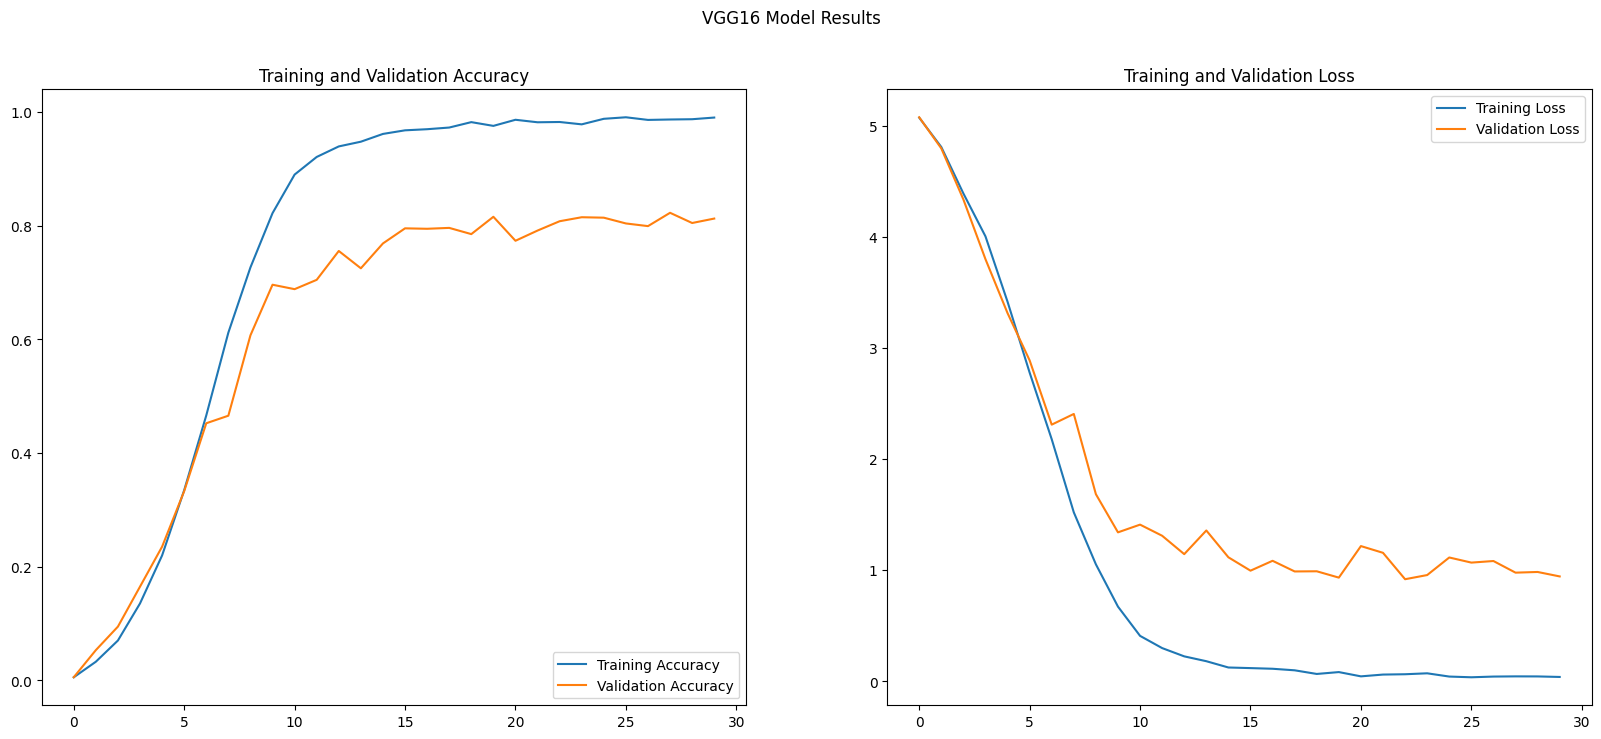

In [22]:
for name, history in model_histories.items():
    plot_model_performance(name, history)

In [23]:
for name, model in models.items():
    test_loss, test_accuracy = model.evaluate(test_dataset)

    print(f'\x1b[34m{name} Model Results:\x1b[0m')
    print(f"Test accuracy: {test_accuracy*100:.2f}%")
    print(f"Test loss: {test_loss:.4f}")
    print()

32/32 [==============================] - 4s 50ms/step - loss: 0.6831 - accuracy: 0.8584
VGG16 Model Results:
Test accuracy: 85.84%
Test loss: 0.6831



Saving models and their training histories

In [ ]:
for name, model in models.items():
    model.save(f'Saved Models/VERA/{name}.keras')
    print(f'Saved {name} Model')

for name, model in model_histories.items():
    with open(f'Model Histories/VERA/{name}.json', 'w') as json_file:
        json.dump(history.history, json_file)


Saved AlexNet Model


FileNotFoundError: [Errno 2] No such file or directory: 'Model Histories/FYODB/AlexNet.json'

NameError: name 'model' is not defined

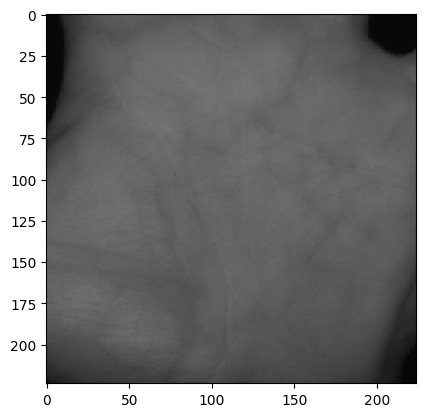

In [ ]:
# img = keras.utils.load_img(
#     "Full Data/roi/001-M/01/001_L_1_1.png", target_size=image_size
# )
# plt.imshow(img)

# img_array = keras.utils.img_to_array(img)
# img_array = tf.expand_dims(img_array, 0)

# predictions = model.predict(img_array)
# predicted_class_index = tf.argmax(predictions[0]).numpy()
# print('Predicted Class:', predicted_class_index)